In [1]:
# Code below is a hack of various other works, inclduing:
# https://github.com/daewoung/Vision-Transformer-MNIST-Pytorch-Lightning/tree/main
# Pytorch Lightning: https://odsc.medium.com/higher-level-pytorch-apis-a-short-introduction-to-pytorch-lightning-47b31c7a45de
# https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
# https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c
# CNNs: https://www.tomasbeuzen.com/deep-learning-with-pytorch/
# AE: https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

torch.manual_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np

from einops.layers.torch import Reduce

In [3]:
batch_size = 128
learning_rate = 1e-3
epochs = 25 # 100

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataset, val_dataset = random_split(training_data, [55000, 5000])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

In [4]:
# data, label = next(iter(train_dataloader))
data, label = next(iter(test_dataloader))
# data.size() # [128, 1, 28, 28]
# len(train_dataloader) # 430
# len(val_dataloader) # 40
# len(test_dataloader) # 79

In [5]:
# data.shape # [batch_size, channel, width, height]

torch.Size([128, 1, 28, 28])

In [6]:
data[0].shape

torch.Size([1, 28, 28])

In [7]:
label

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])

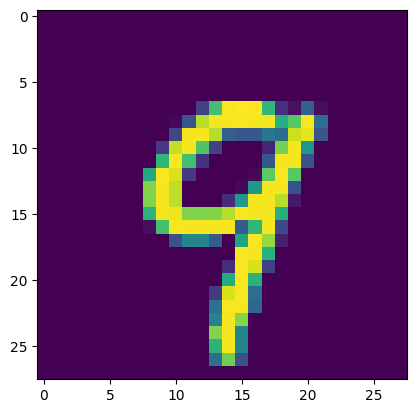

In [8]:
plt.imshow(data[12].reshape(28,28))

In [9]:
project = nn.Conv2d(1, 16, kernel_size=4, stride=4)
# in_chan = 1
# kernel size = patch size 
# stride = patch size
# self.emb_size = channel * patch size * Patch Size = 1 * 4 * 4 = 16
project(data[0].unsqueeze(0)).shape # Images are divided into pathces

torch.Size([1, 16, 7, 7])

In [10]:
class EmbeddingLayer(nn.Module):
    def __init__(self,in_chan, img_size, patch_size, batch_size=128):
        super().__init__()
        self.num_patches = int(img_size / pow(patch_size, 2)) # 49
        self.emb_size = in_chan * patch_size * patch_size # 16
        self.project = nn.Conv2d(in_chan, self.emb_size, kernel_size= patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.emb_size))
        self.positions = nn.Parameter(torch.randn(self.num_patches+ 1, self.emb_size)) # [50,16]
    
 
    def forward(self, x):
        x = self.project(x)
        x = x.view(-1, 49, 16) # [batch_size, 49, 16]
        repeat_cls = self.cls_token.repeat(x.size()[0],1,1) #[batch_size, 1 , 16]
        x = torch.cat((repeat_cls, x), dim=1)
        x += self.positions
        return x

In [11]:
class Multihead(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.multiheadattention = nn.MultiheadAttention(emb_size, num_heads, batch_first = True, dropout=0.2)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attn_output, attention = self.multiheadattention(query, key, value)
        return attn_output, attention


In [12]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.2):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

In [13]:
class VIT(nn.Module):
    def __init__(self, emb_size = 16):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(in_chan=1, img_size=28*28, patch_size=4)
        self.Multihead = Multihead(emb_size, 8)
        self.FFB = FeedForwardBlock(emb_size)
        self.norm = nn.LayerNorm(emb_size)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        
        norm_x = self.norm(x)
        multihead_output, attention = self.Multihead(norm_x)
        
        # residual Function
        output = multihead_output + x
        
        norm_output = self.norm(output)
        FFB = self.FFB(norm_output)
        
        final_out = FFB + output
        
        return final_out, attention

In [14]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_layers, ):
        super().__init__()
        self.layers = nn.ModuleList([VIT() for _ in range(n_layers)])
        
    def forward(self, x):
        for layer in self.layers:
            final_out, attention = layer(x)
        return final_out

In [15]:
class VIT_Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential( TransformerEncoder(n_layers = 5) )
        
        self.Decoder = torch.nn.Sequential(
            torch.nn.Linear(50 * 16, 256), # VIT has 50 x 16 output
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 28 * 28),
            torch.nn.Sigmoid()
        )
        
        self.train_loss = []
        self.val_loss = []
        self.test_loss =[]
        
    def forward(self, x):
        N = len(x) # batch_size
        x = self.Encoder(x)
        x = torch.reshape(x, (N, 50 * 16))
        out_decoder = self.Decoder(x)
        out_decoder = torch.reshape(out_decoder, (N, 1, 28, 28)) # 1 channel
        return out_decoder

    def training_step(self, batch):
        images, classes = batch
        reconstructed = self.forward(images)
        loss_function = nn.MSELoss()
        loss = loss_function(reconstructed, images)
        self.train_loss.append(loss.item())
        return loss
        
    def on_train_epoch_end(self):
        mean_loss = sum(self.train_loss) / len(train_dataloader) 
        # print(f'training_loss :{mean_loss}')
        self.train_loss = []
    
    def validation_step(self, batch):
        images, classes = batch
        reconstructed = self.forward(images)
        loss_function = nn.MSELoss()
        loss = loss_function(reconstructed, images)
        self.val_loss.append(loss.item()) 
        return loss 
    
    def on_validation_epoch_end(self):
        mean_loss = sum(self.val_loss) / len(val_dataloader) 
        print(f'validation loss :{mean_loss}')
        self.val_loss = []

        self.log("val_loss", mean_loss)     
    
    def test_dataloader(self):
        return test_dataloader
    
    def test_step(self, batch):
        images, classes = batch
        reconstructed = self.forward(images)
        loss_function = nn.MSELoss()
        loss = loss_function(reconstructed, images)
        self.test_loss.append(loss.item()) 
        
    def on_test_epoch_end(self):
        mean_loss = sum(self.test_loss) / len(test_dataloader) 
        print(f'val loss :{test_loss}')
        self.test_loss = []
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

In [19]:
# gpus = torch.cuda.device_count()
# gpus # == 1

In [20]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [21]:
model = VIT_Encoder()
trainer = pl.Trainer(max_epochs=epochs, callbacks=[early_stop_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | Encoder | Sequential | 25.8 K
1 | Decoder | Sequential | 738 K 
---------------------------------------
764 K     Trainable params
0         Non-trainable params
764 K     Total params
3.058     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/hbolouri/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


validation loss :0.01162605695426464


/home/hbolouri/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

validation loss :0.012764920014888048


Validation: |                                                                                                 …

validation loss :0.007446834340225905


Validation: |                                                                                                 …

validation loss :0.0055794261978007855


Validation: |                                                                                                 …

validation loss :0.004676848941016942


Validation: |                                                                                                 …

validation loss :0.004088360589230433


Validation: |                                                                                                 …

validation loss :0.0036702283076010646


Validation: |                                                                                                 …

validation loss :0.0033955821010749785


Validation: |                                                                                                 …

validation loss :0.003188793966546655


Validation: |                                                                                                 …

validation loss :0.003060649411054328


Validation: |                                                                                                 …

validation loss :0.002902262599673122


Validation: |                                                                                                 …

validation loss :0.0027932264900300654


Validation: |                                                                                                 …

validation loss :0.002663008915260434


Validation: |                                                                                                 …

validation loss :0.0025710257643368093


Validation: |                                                                                                 …

validation loss :0.0024931129766628144


Validation: |                                                                                                 …

validation loss :0.0024320015218108892


Validation: |                                                                                                 …

validation loss :0.0023724591126665475


Validation: |                                                                                                 …

validation loss :0.0023261783993802966


Validation: |                                                                                                 …

validation loss :0.0022922605858184397


Validation: |                                                                                                 …

validation loss :0.002258808130864054


Validation: |                                                                                                 …

validation loss :0.0022411159647163005


Validation: |                                                                                                 …

validation loss :0.0022073473839554934


Validation: |                                                                                                 …

validation loss :0.0021900124615058304


Validation: |                                                                                                 …

validation loss :0.002158056141342968


Validation: |                                                                                                 …

validation loss :0.0021422038262244314


Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=25` reached.


validation loss :0.0021153843961656095


<Figure size 640x480 with 0 Axes>

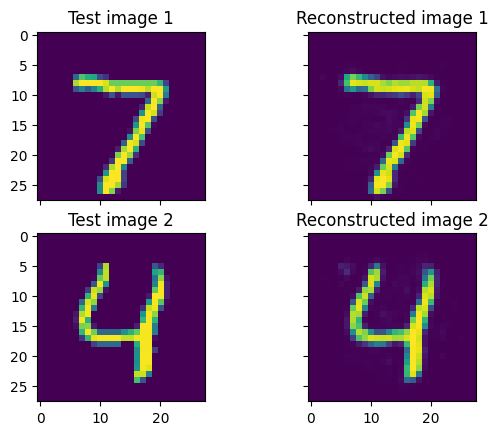

In [79]:
plt.figure()

# subplots(n_rows, n_columns)
fig, fig_list = plt.subplots(2, 2) 

exampleImage = next(iter(test_dataloader))[0][0]
fig_list[0, 0].imshow(exampleImage.reshape(28,28))
fig_list[0, 0].set_title('Test image 1')

tmp = model.forward(exampleImage)
tmp = tmp.detach().numpy()
fig_list[0, 1].imshow(tmp.reshape(28,28))
fig_list[0, 1].set_title('Reconstructed image 1')

exampleImage = next(iter(test_dataloader))[0][4]
fig_list[1, 0].imshow(exampleImage.reshape(28,28))
fig_list[1, 0].set_title('Test image 2')

tmp = model.forward(exampleImage)
tmp = tmp.detach().numpy()
fig_list[1, 1].imshow(tmp.reshape(28,28))
fig_list[1, 1].set_title('Reconstructed image 2')

# Hide x-axis labels and tick labels for top plots and y ticks for right plots.
for ax in fig_list.flat:
    ax.label_outer()

<Figure size 640x480 with 0 Axes>

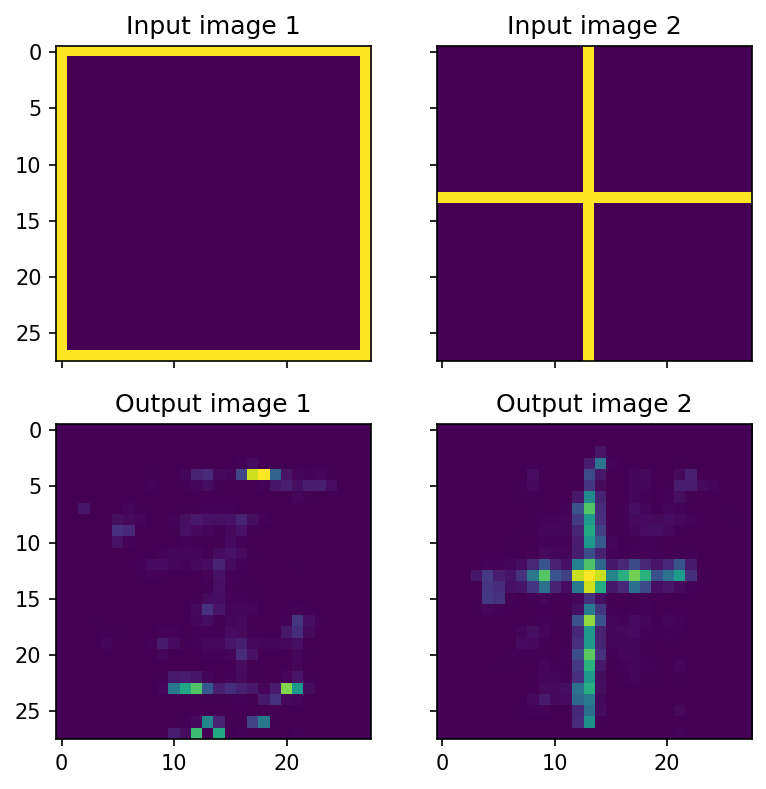

In [74]:
plt.figure()

# subplots(n_rows, n_columns)
fig, fig_list = plt.subplots(2, 2, figsize=(6,6), dpi= 150) 


# for convenince, manipulate an existing test image
y = next(iter(test_dataloader))[0][0] 
y = y.reshape(28,28)

for i in range(28):
    y[i, :] = 0.0 # all pixels == 0

# outer rectangle of 1's:
y[0, :] = 1.0
y[-1, :]= 1.0
y[:, 0] = 1.0
y[:, -1]= 1.0

fig_list[0, 0].imshow(y)
fig_list[0, 0].set_title('Input image 1')

y = y.reshape(1, 28, 28)
tmp = model.forward(y)
tmp = tmp.detach().numpy()
tmp = tmp.reshape(28,28)
# plt.imshow(tmp)
fig_list[1, 0].imshow(tmp)
fig_list[1, 0].set_title('Output image 1')

# Cross:
y = next(iter(test_dataloader))[0][0] 
y = y.reshape(28,28)

for i in range(28):
    y[i, :] = 0.0 # all pixels == 0

y[13:14, :] = 1.0
y[:, 13:14] = 1.0

fig_list[0, 1].imshow(y)
fig_list[0, 1].set_title('Input image 2')

y = y.reshape(1, 28, 28)
tmp = model.forward(y)
tmp = tmp.detach().numpy()
tmp = tmp.reshape(28,28)
# plt.imshow(tmp)
fig_list[1, 1].imshow(tmp)
fig_list[1, 1].set_title('Output image 2')


# # vertical sides:
# y[:, 0] = 1.0
# y[:, -1]= 1.0

# # horizontal sides:
# y[0, :] = 1.0
# y[-1, :]= 1.0

# # 1 vertical:
# y[:, 13:14] = 1.0

# # 1 horizintal:
# y[13:14, :] = 1.0

for ax in fig_list.flat:
    ax.label_outer()

<Figure size 640x480 with 0 Axes>

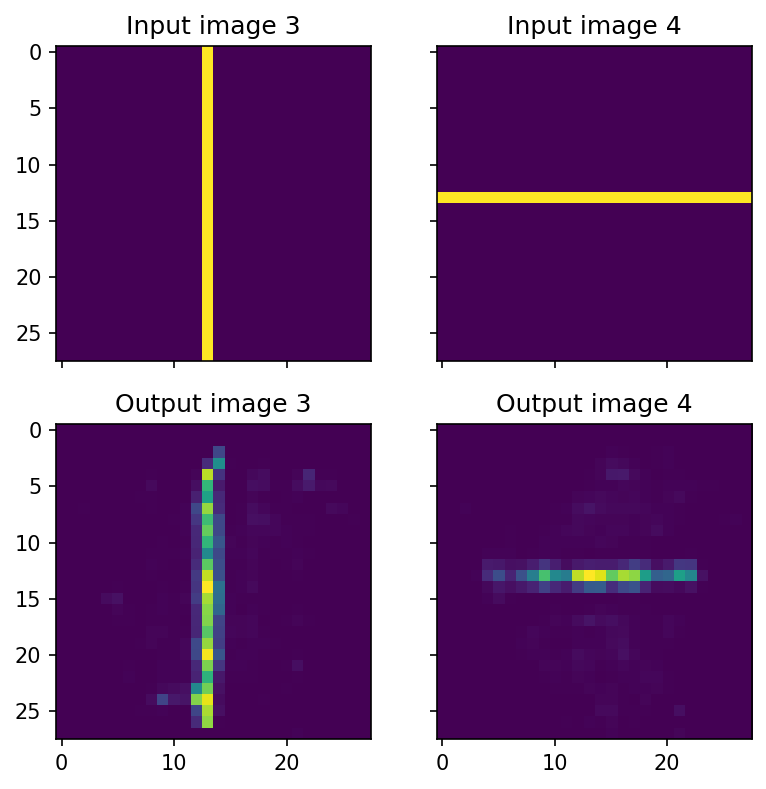

In [77]:
plt.figure()

# subplots(n_rows, n_columns)
fig, fig_list = plt.subplots(2, 2, figsize=(6,6), dpi= 150) 


# for convenince, reset a test image
y = next(iter(test_dataloader))[0][0] 
y = y.reshape(28,28)

for i in range(28):
    y[i, :] = 0.0 # all pixels == 0

# 1 vertical:
y[:, 13:14] = 1.0

fig_list[0, 0].imshow(y)
fig_list[0, 0].set_title('Input image 3')

y = y.reshape(1, 28, 28)
tmp = model.forward(y)
tmp = tmp.detach().numpy()
tmp = tmp.reshape(28,28)
# plt.imshow(tmp)
fig_list[1, 0].imshow(tmp)
fig_list[1, 0].set_title('Output image 3')

# 1 horizintal:
y = next(iter(test_dataloader))[0][0] 
y = y.reshape(28,28)

for i in range(28):
    y[i, :] = 0.0 # all pixels == 0

y[13:14, :] = 1.0

fig_list[0, 1].imshow(y)
fig_list[0, 1].set_title('Input image 4')

y = y.reshape(1, 28, 28)
tmp = model.forward(y)
tmp = tmp.detach().numpy()
tmp = tmp.reshape(28,28)
# plt.imshow(tmp)
fig_list[1, 1].imshow(tmp)
fig_list[1, 1].set_title('Output image 4')


for ax in fig_list.flat:
    ax.label_outer()

<Figure size 640x480 with 0 Axes>

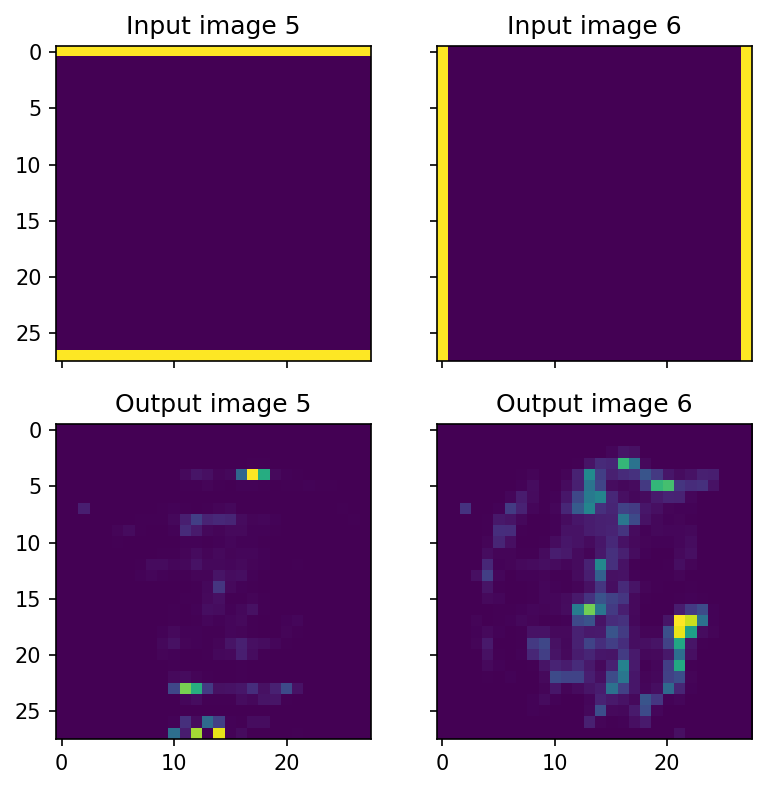

In [78]:
plt.figure()

# subplots(n_rows, n_columns)
fig, fig_list = plt.subplots(2, 2, figsize=(6,6), dpi= 150) 


# for convenince, reset a test image
y = next(iter(test_dataloader))[0][0] 
y = y.reshape(28,28)

for i in range(28):
    y[i, :] = 0.0 # all pixels == 0

# horizontal sides:
y[0, :] = 1.0
y[-1, :]= 1.0

fig_list[0, 0].imshow(y)
fig_list[0, 0].set_title('Input image 5')

y = y.reshape(1, 28, 28)
tmp = model.forward(y)
tmp = tmp.detach().numpy()
tmp = tmp.reshape(28,28)
# plt.imshow(tmp)
fig_list[1, 0].imshow(tmp)
fig_list[1, 0].set_title('Output image 5')

# vertical sides:
y = next(iter(test_dataloader))[0][0] 
y = y.reshape(28,28)

for i in range(28):
    y[i, :] = 0.0 # all pixels == 0

y[:, 0] = 1.0
y[:, -1]= 1.0

fig_list[0, 1].imshow(y)
fig_list[0, 1].set_title('Input image 6')

y = y.reshape(1, 28, 28)
tmp = model.forward(y)
tmp = tmp.detach().numpy()
tmp = tmp.reshape(28,28)
# plt.imshow(tmp)
fig_list[1, 1].imshow(tmp)
fig_list[1, 1].set_title('Output image 6')


# # 1 vertical:
# y[:, 13:14] = 1.0

# # 1 horizintal:
# y[13:14, :] = 1.0

for ax in fig_list.flat:
    ax.label_outer()

In [25]:
# trainer.test()
os.getcwd()

'/mnt/d/scGPT'

In [31]:
# Clear logs from previous runs
# %rm -rf ./lightning_logs/OLD/

In [27]:
%load_ext tensorboard 
%tensorboard --logdir lightning_logs/

In [82]:
import pickle 

with open('mnist_ViT_AE4_model.pkl', 'wb') as f: 
    pickle.dump(model, f)

f.close()